# Multi-Scenario MORDM Gelderland
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate possible strategies for the Gelderland province to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies for the Gelderland province, namely minimizing casualties and damages across the model runtime in dike rings 1-3 and minimizing dike investment costs for all dike rings. 

## Imports

In [9]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px
import altair as alt
import plotly.io as pio
import plotly
import kaleido

# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
#from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform as well as other parameters used in this notebook

In [10]:
# Number of nfes for the Model
n_nfe = 5000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "./results/5000Scenarios_NullPolicy_PF1.tar.gz"

#Province name
province = "DikeRing3"

## Model Specification
Problem Formulation 6, specified in the problem_formulation.py file is calles to initiate the dike model from Gelderlands framing. 

In [11]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(6)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [12]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded successfully from /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/5000Scenarios_NullPolicy_PF1.tar.gz


In [13]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario
Due to limited computational resources, we ran 20000 function evaluations in the epsilon-NSGA II multi-objective evolutionary algorithm (MOEA) implemented in the ema_workbench. As a convergence metric, the epsilon progress was used. 

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started with 1 workers
5084it [56:44,  1.49it/s]                                                      
[MainProcess/INFO] optimization completed, found 165 solutions
[MainProcess/INFO] terminating pool


In [6]:
results, convergence = results_epsilon_0_1

NameError: name 'results_epsilon_0_1' is not defined

In [ ]:
results.iloc[:,:31].columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'],
      dtype='object')

In [14]:
# Unpack the values
experiments_convergence, convergence = results_epsilon_0_1

# Separate experiments and outcomes
experiments = experiments_convergence.iloc[:, :31]  # adjust index as per your data
outcomes = experiments_convergence.iloc[:, 31:]

# Combine experiments and outcomes into one tuple
optim_results = (experiments, outcomes)

# Save the optimization results (experiments and outcomes)
save_results(optim_results, "./results/"+str(n_nfe)+"nfe_BaseCaseMORDM_"+province+"_optim_results.tar.gz")

# Save the convergence data separately as a CSV file
convergence.to_csv("./results/"+str(n_nfe)+"nfe_BaseCaseMORDM_"+province+"_convergence.csv")


NameError: name 'results_epsilon_0_1' is not defined

In [15]:
convergence= pd.read_csv("./results/5000nfe_BaseCaseMORDM_DikeRing3_convergence.csv")
results=load_results("./results/5000nfe_BaseCaseMORDM_DikeRing3_optim_results.tar.gz")

[MainProcess/INFO] results loaded successfully from /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/5000nfe_BaseCaseMORDM_DikeRing3_optim_results.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

In [20]:
fig0 = px.line(convergence, x = "nfe", y = "epsilon_progress", title="Epsilon Progress")
fig0.show()
fig0.write_image("./plots/EpsilonProgress_dike3_iter1.png")

As it can be seen in the plot, the algorithm did not fully converge. However, due to limited computational resources we decided to go forward with the solutions found after 20.000 function evaluations. For a more precice analysis, we encourage other researchers to use high-performance computational clusters to run the MOEA until full convergence is reached.

## Show tradeoffs in the resulting optimal policies
The algorithm found 973 solutions, which are displayed in the following section of the notebook.   

In [21]:
# extract DataFrame from the tuple
df = results[1]

df1=pd.DataFrame(df)
df1=df1.reset_index()
fig1 = px.parallel_coordinates(df1, labels= 
    {"A3 Expected Annual Damage" : "A3 Damage", 
    "A3 Aggr Expected Number of Deaths" : "A3 Casualties", 
    "A3 Dike Investment Costs" : "Dike Investment Costs", 
    "Room for River Investment Costs" : "RfR Investment Costs",
    "Evacuation Costs" : "Evacuation Costs"}, 
    color=df1.index, 
    dimensions = ["A3 Expected Annual Damage", 
                  "A3 Aggr Expected Number of Deaths", 
                  "A3 Dike Investment Costs", 
                  "Room for River Investment Costs",
                  "Evacuation Costs"])
fig1.update_layout(showlegend=False)


fig1.show()
fig1.write_image("./plots/ParallelPlot_dike3_iter1.png")

![Tradeoffs](../figures/Gelderland_Tradeoffs_1ReferenceScenario.png)


To show the tradeoffs more clearly, we aggregate the costs and the expected number of casualties, as well as the investment costs with the evacuation costs

In [22]:
# Split the tuple into a DataFrame and a dictionary
results_df, results_dict = results

# Convert the dictionary into a DataFrame
results_dict_df = pd.DataFrame({'A3 Expected Annual Damage': results_dict['A3 Expected Annual Damage'],
                                'A3 Aggr Expected Number of Deaths': results_dict['A3 Aggr Expected Number of Deaths'],
                                'A3 Dike Investment Costs': results_dict['A3 Dike Investment Costs'],
                               'Room for River Investment Costs': results_dict['Room for River Investment Costs'],
                               'Evacuation Costs': results_dict['Evacuation Costs']})

# Concatenate this DataFrame with the original results DataFrame
results_combined = pd.concat([results_df, results_dict_df], axis=1)

results_combined

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,0,0,0,0,0,0,1,1,1,1,...,5,5,7,2,7,1.391253e+08,0.096114,0.0,455700000.0,4335.781610
1,0,0,0,0,0,0,0,0,0,0,...,5,4,3,2,5,1.864995e+09,0.553527,0.0,0.0,89669.863379
2,1,0,0,0,0,0,1,1,1,1,...,7,2,3,5,4,3.008581e+08,0.086518,0.0,419100000.0,14922.120156
3,0,0,0,0,0,0,0,1,0,0,...,4,0,4,5,7,3.321688e+08,0.080716,24198032.0,30700000.0,19385.981939
4,0,0,0,0,0,0,0,1,0,0,...,0,3,0,6,6,1.783696e+09,1.239588,0.0,30700000.0,53140.743325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0,0,0,0,0,0,0,0,0,...,4,4,7,6,6,1.736878e+09,0.407700,20299287.0,0.0,115935.767485
161,0,0,0,0,0,0,0,0,0,0,...,1,4,0,6,7,6.001396e+08,0.436128,24198032.0,0.0,21867.360186
162,0,0,0,0,0,0,1,1,1,1,...,1,0,3,4,6,9.443128e+06,0.002698,0.0,213300000.0,28291.735456
163,0,0,0,0,0,0,1,0,0,0,...,5,4,6,7,1,1.129667e+09,0.324621,20299287.0,30700000.0,66005.500148


In [23]:
results_agg = results_combined.loc[:, ["A3 Expected Annual Damage", "A3 Aggr Expected Number of Deaths", "A3 Dike Investment Costs", "Room for River Investment Costs", "Evacuation Costs"]]

results_agg["Expected Casualties"] = results_agg["A3 Aggr Expected Number of Deaths"]
results_agg["Expected Damage"] = results_agg["A3 Expected Annual Damage"]
results_agg["Traditional Costs"] = results_agg["A3 Dike Investment Costs"] + results_agg["Evacuation Costs"] + results_agg["Room for River Investment Costs"]
results_agg

,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs,Expected Casualties,Expected Damage,Traditional Costs
0,1.391253e+08,0.096114,0.0,455700000.0,4335.781610,0.096114,1.391253e+08,4.557043e+08
1,1.864995e+09,0.553527,0.0,0.0,89669.863379,0.553527,1.864995e+09,8.966986e+04
2,3.008581e+08,0.086518,0.0,419100000.0,14922.120156,0.086518,3.008581e+08,4.191149e+08
3,3.321688e+08,0.080716,24198032.0,30700000.0,19385.981939,0.080716,3.321688e+08,5.491742e+07
4,1.783696e+09,1.239588,0.0,30700000.0,53140.743325,1.239588,1.783696e+09,3.075314e+07
...,...,...,...,...,...,...,...,...
160,1.736878e+09,0.407700,20299287.0,0.0,115935.767485,0.407700,1.736878e+09,2.041522e+07
161,6.001396e+08,0.436128,24198032.0,0.0,21867.360186,0.436128,6.001396e+08,2.421990e+07
162,9.443128e+06,0.002698,0.0,213300000.0,28291.735456,0.002698,9.443128e+06,2.133283e+08
163,1.129667e+09,0.324621,20299287.0,30700000.0,66005.500148,0.324621,1.129667e+09,5.106529e+07


In [24]:
fig2 = px.parallel_coordinates(results_agg, dimensions=["Expected Casualties","Expected Damage", "Traditional Costs"], color = results_agg.index)
fig2.update_layout(showlegend=False)
fig2.show()
fig2.write_image("./plots/Aggr_ParallelPlot_dike3_iter1.png")

![](../figures/Gelderland_Tradeoffs_Aggr_1ReferenceScenario.png)

## Re-Evaluate under deep uncertainty
For evaluating the promising policies under deep uncertainty, we set a hard limit on one expected casualties below 0.001 and expected damages below €100.000. 

In [25]:
temp=results_combined.iloc[:,31:]
temp.describe()

,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
count,1.650000e+02,165.000000,1.650000e+02,1.650000e+02,165.000000
mean,1.001771e+09,0.517343,9.793703e+06,7.448848e+07,52677.479959
std,7.291727e+08,0.541044,1.095330e+07,1.592752e+08,40434.596440
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,3.008581e+08,0.122832,0.000000e+00,0.000000e+00,19226.603061
50%,6.716627e+08,0.410553,0.000000e+00,3.070000e+07,52822.871876
75%,1.784346e+09,0.551092,2.029929e+07,6.140000e+07,88681.999268
max,1.865650e+09,3.343016,2.640338e+07,9.679000e+08,145745.442862


In [26]:
#results_subset = results_combined[(results_combined["A3 Aggr Expected Number of Deaths"] < 0.01) &  (results_combined["A3 Expected Annual Damage"] < 100000)]
results_subset = results_combined[(results_combined["A3 Aggr Expected Number of Deaths"] < 0.05)  | (results_combined["A3 Expected Annual Damage"] < 1.7e7)]

results_subset.shape

(15, 36)

In [27]:
results_subset

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
12,0,0,0,0,0,0,1,1,1,1,...,4,2,6,6,6,1.391194e+08,0.032036,0.000000e+00,455700000.0,9197.379454
37,0,0,0,0,0,0,1,0,0,0,...,6,4,4,3,5,8.853540e+07,0.033614,2.419803e+07,30700000.0,38996.163240
65,0,0,0,0,0,0,1,1,1,1,...,1,4,6,5,7,8.056387e+07,0.023527,0.000000e+00,455700000.0,15884.411737
66,0,0,0,0,0,0,1,1,1,1,...,5,5,6,5,7,1.390560e+08,0.032016,0.000000e+00,967900000.0,8645.078436
76,0,0,0,0,0,0,0,1,0,0,...,0,0,0,5,4,0.000000e+00,0.000000,2.419803e+07,30700000.0,59978.728796
93,0,0,0,0,0,0,1,0,1,0,...,2,4,7,5,6,0.000000e+00,0.000000,2.216782e+07,61400000.0,0.000000
95,1,0,0,0,0,0,1,1,1,1,...,5,4,7,3,10,6.344699e+07,0.020227,0.000000e+00,540300000.0,10909.631126
107,0,0,0,0,0,0,1,0,0,0,...,4,4,7,5,6,0.000000e+00,0.000000,2.419803e+07,30700000.0,0.000000
110,0,0,0,0,0,0,1,1,1,1,...,5,5,7,4,10,2.051933e+07,0.005862,0.000000e+00,711800000.0,12152.916330
116,0,0,0,0,0,0,0,0,0,0,...,4,4,6,5,0,0.000000e+00,0.000000,2.640338e+07,0.0,0.000000


We further use the remaining policies to test them under deep uncertainty by running the policies for 1000 scenarios each. 

In [28]:
policies = results_subset.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [29]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

KeyboardInterrupt: 

In [ ]:
#Save results
save_results(results, "./results/DeepUncertainty15policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

In [30]:
#Load results
results = load_results("./results/DeepUncertainty5policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")
experiments, outcomes = results


[MainProcess/INFO] results loaded successfully from /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/DeepUncertainty5policies_1000scenarios_DikeRing3.tar.gz


## Robustness Evaluation
### Signal-to-noise Ratio
To find the most robust policy, we rate the different policies by calculating the signal-to-noise ratio. For those model outcomes which are to be minimized, this metric multiplies the mean over all scenarios times the standard deviation. In that sense, the higher the signal-to-noise ratio is for a given policy over the outcomes, the less robust the policy performs. 

In [31]:
#Define a function to calculate the signal-to-noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [32]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        # Check if outcome.name is in outcomes.keys()
        if outcome.name in outcomes.keys():
            value  = outcomes[outcome.name][logical]
            sn_ratio = s_to_n(value, outcome.kind)
            scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores = scores.reset_index()
scores

,index,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,76,1.568993e+16,0.000672,0.090145,0.0,3.563563e+08
1,93,8.207220e+15,0.023680,0.000000,0.0,0.000000e+00
2,107,9.762702e+15,0.029057,0.090145,0.0,0.000000e+00
3,116,1.230217e+16,0.038493,0.098360,0.0,0.000000e+00
4,127,7.162470e+15,0.020510,0.075621,0.0,0.000000e+00


For a better visual understanding, we will plot the stn ratio in a parallel coordinates plot. 

In [33]:
fig3 = px.parallel_coordinates(
    scores,
    labels= {
        "A3 Expected Annual Damage" : "A3 Damage",
        "A3 Aggr Expected Number of Deaths" : "A3 Casualties",
        "A3 Dike Investment Costs" : "Dike Investment Costs",
        "Room for River Investment Costs" : "RfR Investment Costs",
        "Evacuation Costs" : "Evacuation Costs"
    },
    color = scores.index,
    dimensions=[
        "A3 Expected Annual Damage",
        "A3 Aggr Expected Number of Deaths",
        "A3 Dike Investment Costs",
        "Room for River Investment Costs",
        "Evacuation Costs"
    ]
)
#fig3.write_image("SignalNoise.png")
fig3.show()
fig3.write_image("./plots/Selected_ParralelPlot_dike3_iter1.png")

We find some robust policies, as seen in the graph.

![](../figures/Gelderland_stnr.png)



### Maximum Regret
Another robustness criterion is the maximum regret measure. We again calculate this measure for every policy selected

In [34]:
def calculate_regret(data, best):
    return np.abs(best-data)

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


In [35]:
max_regret = pd.DataFrame(max_regret)
max_regret = max_regret.reindex()

In [39]:
fig = px.imshow(max_regret/max_regret.max(), labels=dict(x="Outcomes", y = "Policies", color = "Maximum regret"))
fig.show()
fig.write_image("./plots/MaxRegret_dike3_iter1.png")

Although not numbered, it can clearly be seen that policy 7, for example, shows little regret for outcomes 2, 4 and 6. Therefore this policy might be a robust solution when only considering the initial reference case scenario based on the worst deaths. However, we continue looking for more robust solutions across multiple reference scenarios using the PRIM algorithm. 

## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. For Gelderland, we focus on such scenarios where deaths and damages occur, and where the total costs are above 4 Billion €. 

In [41]:

condition= {}


condition["condition1"] = outcomes["A3 Expected Annual Damage"] + outcomes["A3 Aggr Expected Number of Deaths"]

condition["condition2"] = outcomes["Evacuation Costs"] + outcomes["Room for River Investment Costs"]

condition1 = condition["condition1"] > 0

condition2 = condition["condition2"] > 4e9

In [42]:
outcomes=pd.DataFrame(outcomes)
outcomes

,A3 Expected Annual Damage,A3 Aggr Expected Number of Deaths,A3 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,0.000000e+00,0.000000,2.419803e+07,30700000.0,14720.294665
1,6.710204e+07,0.015348,2.419803e+07,30700000.0,4134.907691
2,0.000000e+00,0.000000,2.419803e+07,30700000.0,1743.042959
3,0.000000e+00,0.000000,2.419803e+07,30700000.0,15074.128227
4,0.000000e+00,0.000000,2.419803e+07,30700000.0,19984.951610
...,...,...,...,...,...
4995,0.000000e+00,0.000000,2.029929e+07,92100000.0,0.000000
4996,0.000000e+00,0.000000,2.029929e+07,92100000.0,0.000000
4997,0.000000e+00,0.000000,2.029929e+07,92100000.0,0.000000
4998,0.000000e+00,0.000000,2.029929e+07,92100000.0,0.000000


In [43]:
# Prepare to do prim
from ema_workbench.analysis import prim

# Set the output to the category that we are interested in for this run
outcome_entry = outcomes["Evacuation Costs"] + outcomes["Room for River Investment Costs"]

x = experiments.iloc[:,0:19]
# Set our output threshold to be the 90th percentile of all of those outputs
y_limit = np.quantile(outcome_entry, 0.5)

# Only select outputs that are above this threshold
y = np.array([value > y_limit for value in outcome_entry])

# Conduct our prim analysis using a threshold of 0.8
prim_alg = prim.Prim(x, y, threshold=0.6)

# Get the box that prim found for us
box1 = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 0.6, mass: 0.187, coverage: 0.2244, density: 0.6 restricted_dimensions: 2


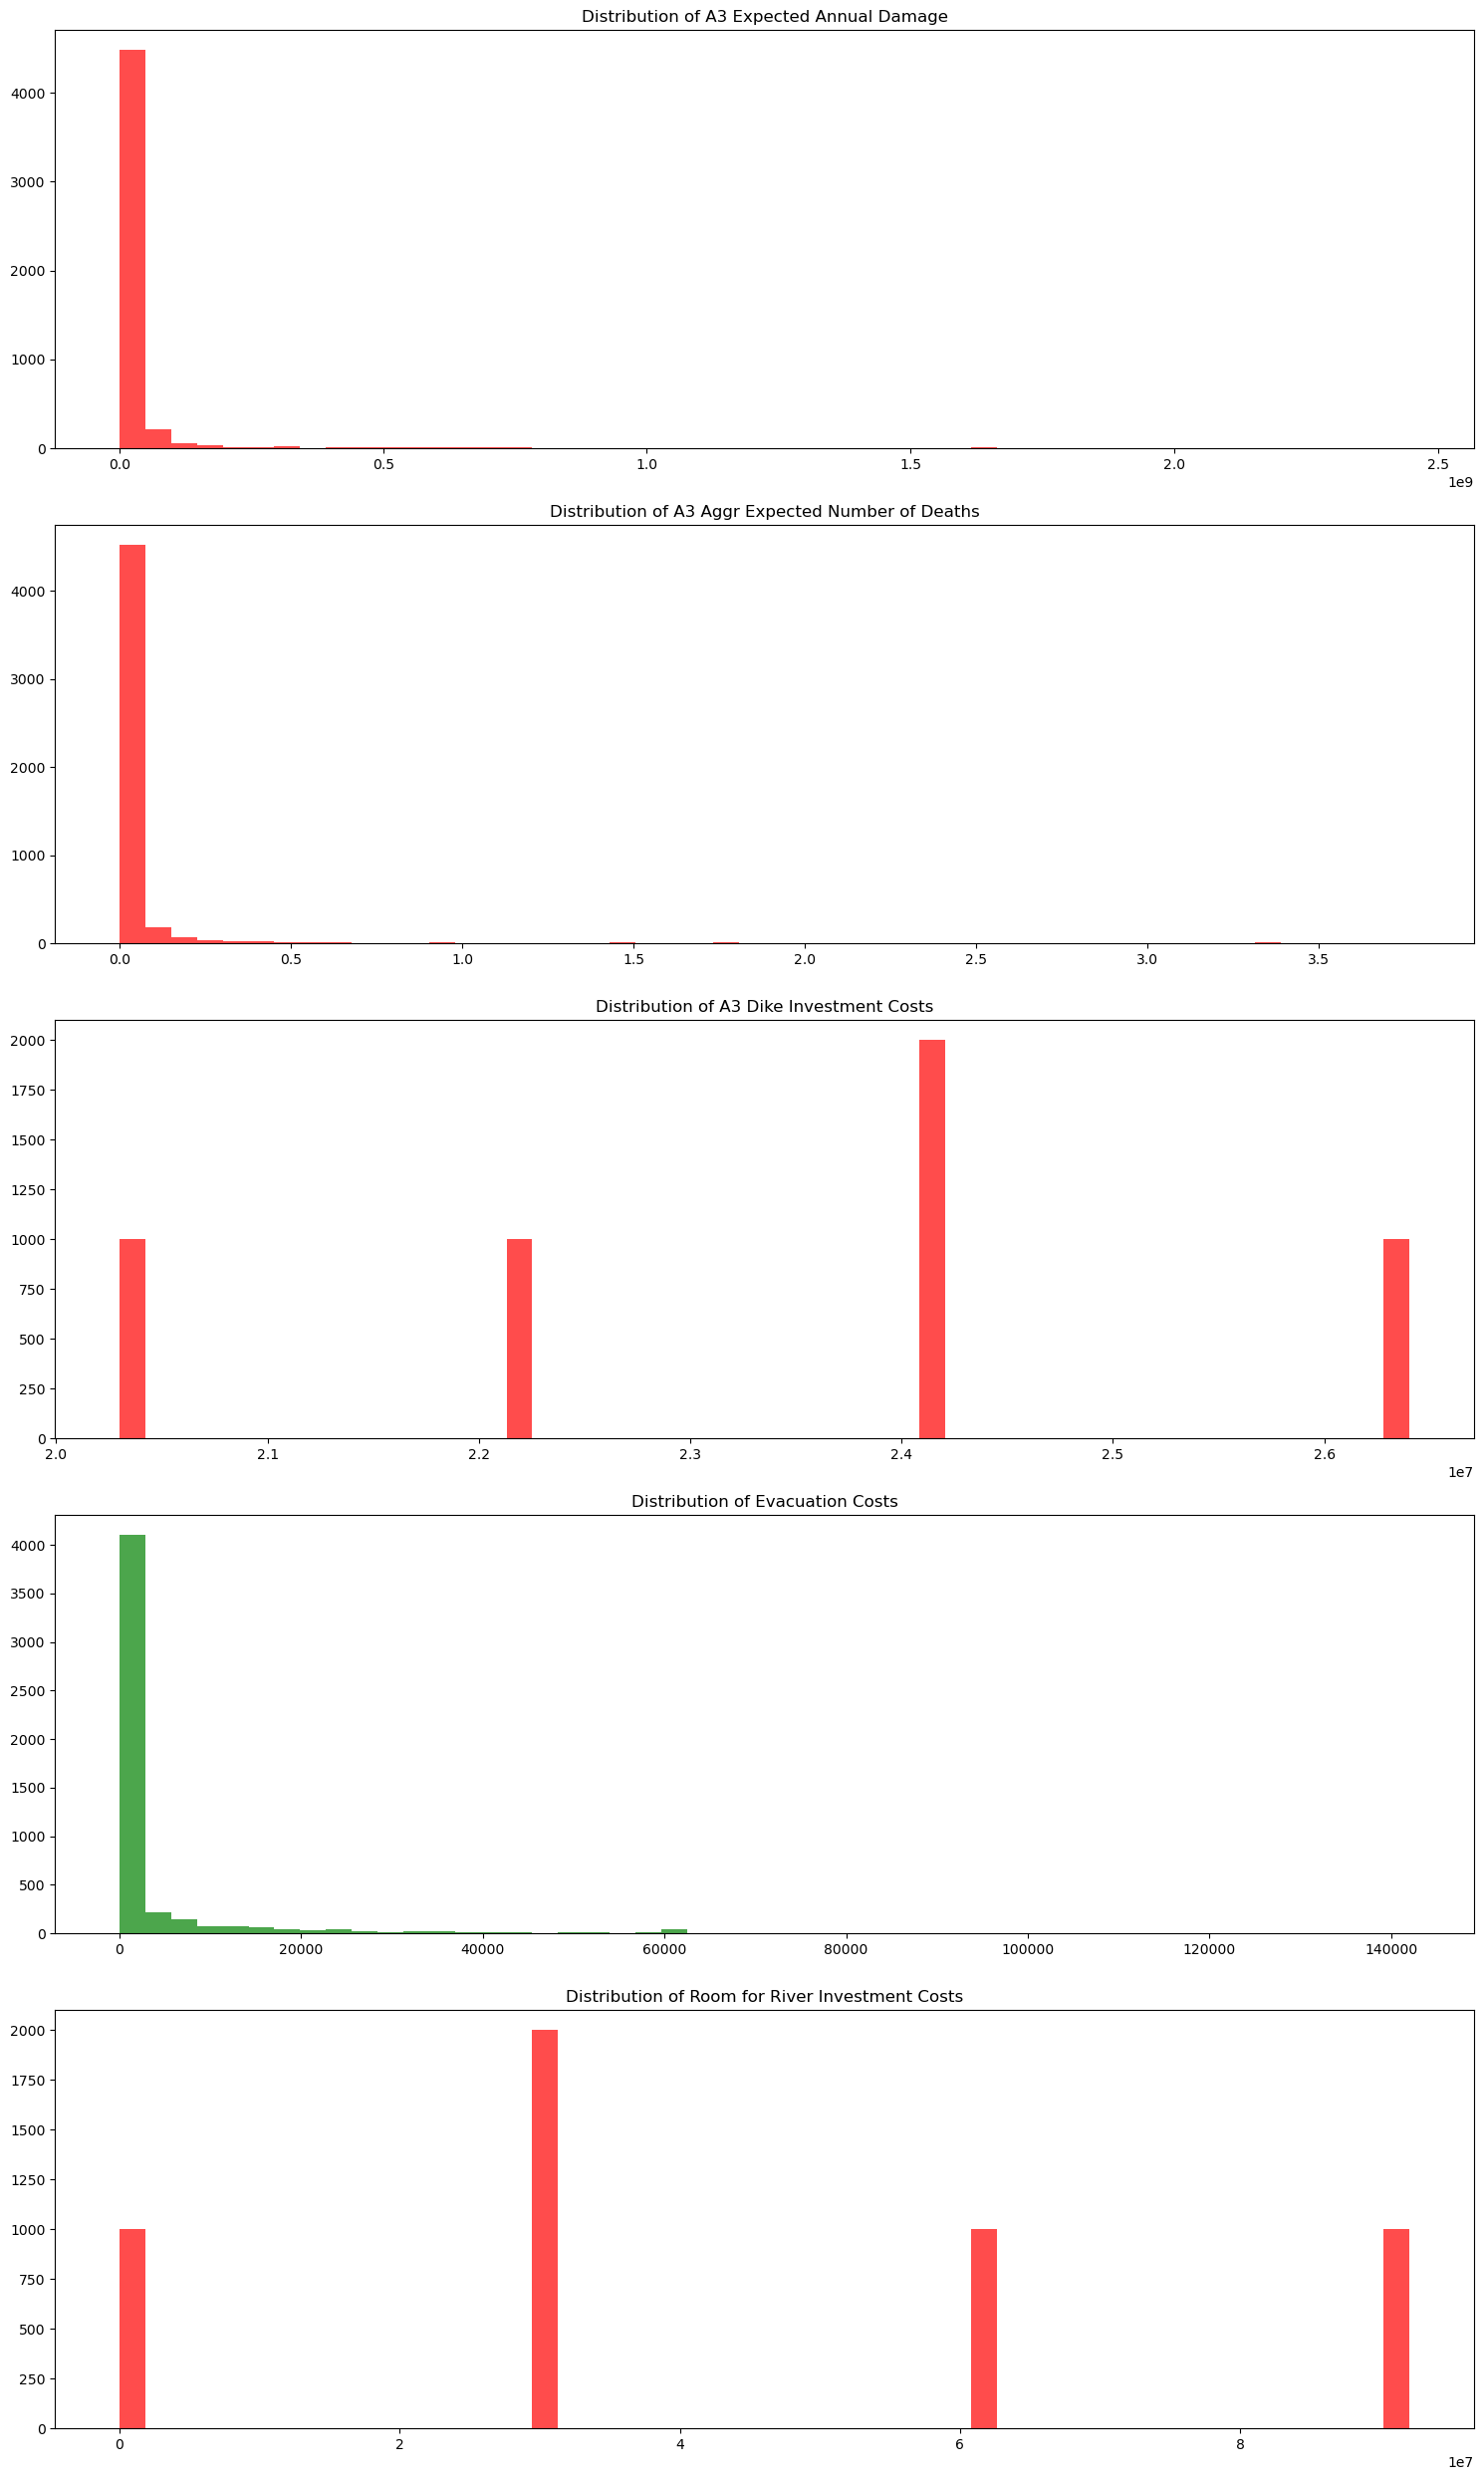

In [44]:
fig, axs = plt.subplots(5, figsize=(15,25))


# Create a histogram for "A3 Expected Annual Damage"
axs[0].hist(outcomes["A3 Expected Annual Damage"], bins=50, color='red', alpha=0.7)
axs[0].set_title('Distribution of A3 Expected Annual Damage')

# Create a histogram for "A3 Aggr Expected Number of Deaths"
axs[1].hist(outcomes["A3 Aggr Expected Number of Deaths"], bins=50, color='red', alpha=0.7)
axs[1].set_title('Distribution of A3 Aggr Expected Number of Deaths')

# Create a histogram for "A3 Dike Investment Costs"
axs[2].hist(outcomes["A3 Dike Investment Costs"], bins=50, color='red', alpha=0.7)
axs[2].set_title('Distribution of A3 Dike Investment Costs')

# Create a histogram for "Evacuation Costs"
axs[3].hist(outcomes["Evacuation Costs"], bins=50, color='green', alpha=0.7)
axs[3].set_title('Distribution of Evacuation Costs')

# Create a histogram for "Room for River Investment Costs"
axs[4].hist(outcomes["Room for River Investment Costs"], bins=50, color='red', alpha=0.7)
axs[4].set_title('Distribution of Room for River Investment Costs')


# Display the plot
plt.tight_layout()
plt.show()


In [45]:
x = experiments.iloc[:,0:19]
y = (condition1 | condition2)
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 1244 cases of interest
[MainProcess/INFO] mean: 0.9846153846153847, mass: 0.065, coverage: 0.2572347266881029, density: 0.9846153846153847 restricted_dimensions: 7


In [46]:
box.inspect_tradeoff()

/Users/philipmuller/opt/anaconda3/envs/mbdm/lib/python3.11/site-packages/altair/utils/core.py:283: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.VConcatChart(...)

We select box 10, as it shows a good mixture between coverage and density. 

In [47]:
n_box = 10
box.inspect(n_box)
#print(province)

coverage     0.998392
density      0.417479
id          10.000000
mass         0.595000
mean         0.417479
res_dim      1.000000
Name: 10, dtype: float64

             box 10                                 
                min       max qp value      qp value
A.3_pfail  0.000816  0.594715      NaN  4.540846e-90



[None]

In [48]:
box.select(n_box)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}

In [49]:
#Save results
save_results([scens_in_box.reindex(), outcomes_in_box], './results/mordm_'+province+ str(n_box)+'.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/philipmuller/Documents/GitHub/model-based-decision-making/final assignment/results/mordm_DikeRing310.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 

In [50]:
#Load results
# mordm_results = load_results('../results/mordm_29_Gelderland.tar.gz')
results_df = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), pd.DataFrame(outcomes_in_box)], axis = 1)

In [51]:
#Sum up Deaths and Damages
results_df["Deaths Aggregated"] =  results_df["A3 Aggr Expected Number of Deaths"]
results_df["Damages Aggregated"] =results_df["A3 Expected Annual Damage"]

In [52]:
#Get the three reference scenarios
scenario_indices = [results_df.sort_values(["Evacuation Costs"]).tail(1).index[0], 
                    results_df.sort_values(["Deaths Aggregated"]).tail(1).index[0], 
                    results_df.sort_values(["Damages Aggregated"]).tail(1).index[0]]
selected = results_df.iloc[scenario_indices, 0:19]


In [53]:
#Create the three reference case scenario instances
scenarios_mordm = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

### Optimization run 2, now for 3 reference case scenarios
We now search for optimal policies utilizing the three new refence scenarios specified above. For reasons already mentioned, we again use 20000 nfes and the epsilon progress to check for convergence

In [60]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=n_nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []

for scenario in scenarios_mordm:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 1e4, dike_model, convergence_metrics, epsilons))

[MainProcess/INFO] pool started with 1 workers
5082it [1:01:03,  1.39it/s]                                                    
[MainProcess/INFO] optimization completed, found 276 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 1 workers
5086it [59:05,  1.43it/s]                                                      
[MainProcess/INFO] optimization completed, found 284 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 1 workers
5087it [59:56,  1.41it/s]                                                      
[MainProcess/INFO] optimization completed, found 226 solutions
[MainProcess/INFO] terminating pool


In [70]:
# Unpack the values
experiments_convergence, convergence = results[0]
# Separate experiments and outcomes
experiments = experiments_convergence.iloc[:, :31]  # adjust index as per your data
outcomes = experiments_convergence.iloc[:, 31:]
# Combine experiments and outcomes into one tuple
optim_results = (experiments, outcomes)


In [71]:

# Save the optimization results (experiments and outcomes)
save_results(optim_results, "./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference1.tar.gz")
# Save the convergence data separately as a CSV file
convergence.to_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference1.csv")

[MainProcess/INFO] results saved successfully to C:\Users\NKondhalkar\Documents\final assignment\results\msmordm5000nfe_DikeRing3_optim_results_reference1.tar.gz


In [55]:
# Unpack the values
experiments_convergence, convergence = results[1]
# Separate experiments and outcomes
experiments = experiments_convergence.iloc[:, :31]  # adjust index as per your data
outcomes = experiments_convergence.iloc[:, 31:]
# Combine experiments and outcomes into one tuple
optim_results = (experiments, outcomes)
# Save the optimization results (experiments and outcomes)
save_results(optim_results, "./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference2.tar.gz")
# Save the convergence data separately as a CSV file
convergence.to_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference2.csv")

# Unpack the values
experiments_convergence, convergence = results[2]
# Separate experiments and outcomes
experiments = experiments_convergence.iloc[:, :31]  # adjust index as per your data
outcomes = experiments_convergence.iloc[:, 31:]
# Combine experiments and outcomes into one tuple
optim_results = (experiments, outcomes)
# Save the optimization results (experiments and outcomes)
save_results(optim_results, "./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference3.tar.gz")
# Save the convergence data separately as a CSV file
convergence.to_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference3.csv")

IndexError: list index out of range

In [17]:
# Load results
results = []
results.append(load_results("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference1.tar.gz"))
results.append(load_results("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference2.tar.gz"))
results.append(load_results("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_optim_results_reference3.tar.gz"))


# Load convergence data
convergence = []
convergence.append(pd.read_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference1.csv"))
convergence.append(pd.read_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference2.csv"))
convergence.append(pd.read_csv("./results/msmordm"+str(n_nfe)+"nfe_"+province+"_convergence_reference3.csv"))


[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\msmordm5000nfe_DikeRing3_optim_results_reference1.tar.gz
[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\msmordm5000nfe_DikeRing3_optim_results_reference2.tar.gz
[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\msmordm5000nfe_DikeRing3_optim_results_reference3.tar.gz


In [20]:
convergence

[   Unnamed: 0  epsilon_progress   nfe
 0           0                 0     0
 1           1                32   100
 2           2               268  1197
 3           3               481  2292
 4           4               571  3390
 5           5               662  4486
 6           6               714  5082,
    Unnamed: 0  epsilon_progress   nfe
 0           0                 0     0
 1           1                38   100
 2           2               282  1198
 3           3               515  2296
 4           4               628  3393
 5           5               767  4487
 6           6               819  5086,
    Unnamed: 0  epsilon_progress   nfe
 0           0                 0     0
 1           1                42   100
 2           2               267  1197
 3           3               516  2294
 4           4               634  3392
 5           5               749  4491
 6           6               810  5087]

### Check for convergence

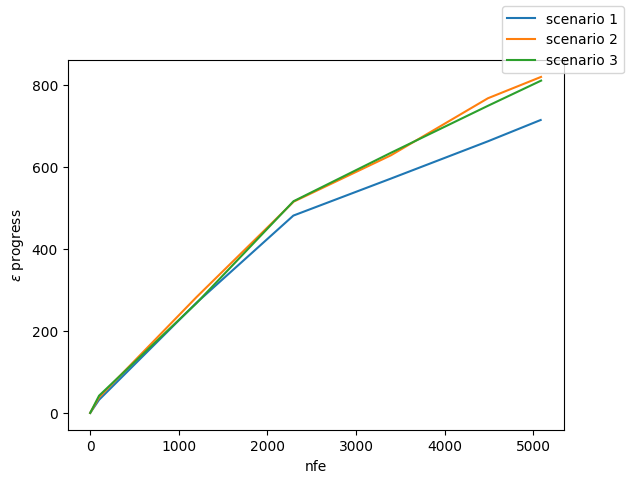

In [21]:
fig, ax2 = plt.subplots(ncols=1)

for i, df in enumerate(convergence):
    ax2.plot(df["nfe"], df["epsilon_progress"], label=f'scenario {i+1}')

ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()


As we can see, the algorithm shows a similar convergence behavior across all three reference case scenarios. It does however not fully converge, which - in further research - should be improved upon. 

## Selection of promising policies
We now again continue to select promising policies, first by plotting the trade-offs involved and then by subsetting the policies based on thresholds. 

In [28]:
pd.DataFrame(results[0][0])

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,1,0,0,...,6,6,0,0,5,6,2,1,9,9
1,0,0,0,0,0,0,0,0,1,0,...,6,5,0,0,6,8,1,5,1,5
2,0,0,0,0,0,0,0,1,1,0,...,1,2,0,0,1,6,10,2,1,6
3,0,0,0,0,0,0,0,0,1,0,...,4,4,0,0,7,8,6,2,1,10
4,1,1,0,0,0,0,1,1,1,0,...,0,3,0,0,6,6,7,5,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,5,5,4,0,0,1
272,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,7,4,4,4,4,1
273,0,0,0,0,0,0,0,0,1,0,...,2,2,0,0,4,2,0,2,6,4
274,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,5,1,4,2,7,2


In [30]:
#Make a dataframe out of all results
ms_results_df = pd.concat([pd.DataFrame(results[0][1]),pd.DataFrame(results[1][1]), pd.DataFrame(results[2][1])], axis=0)
ms_results_df = ms_results_df.reset_index(drop=True)

In [32]:
fig4 = px.parallel_coordinates(ms_results_df, labels= {"A3 Expected Annual Damage" : "A3 Damage", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A3 Dike Investment Costs" : "Dike Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs","Evacuation Costs":"Evacuation Costs"}, color = ms_results_df.index, dimensions= ["A3 Expected Annual Damage", "A3 Aggr Expected Number of Deaths", "A3 Dike Investment Costs", "Room for River Investment Costs","Evacuation Costs"])
fig4.show()

We can observe similar trade-offs as before, however, the newly found policies overall show a much better performance when it comes to casualties and damages. 

![Tradeoffs](../figures/Gelderland_Tradeoffs_3ReferenceScenario.png)


## Selection of promising policies
We select from the solutions found only these which lead to no expected deaths, no expected damage and no evacuation costs. From these selection onwards, due to comparability with the other notebooks and computational resources, we select the 10 policies with lowest total costs (Dike investment costs and Room for River costs combined)

In [33]:
ms_results_subset = ms_results_df[
    ((ms_results_df["A3 Aggr Expected Number of Deaths"]) == 0) &
    ((ms_results_df["A3 Expected Annual Damage"]) == 0) &
    ((ms_results_df["Evacuation Costs"]) == 0) ]

ms_results_subset["Total Costs"] = ms_results_subset["A3 Dike Investment Costs"] + ms_results_subset["Room for River Investment Costs"] 


C:\Users\NKondhalkar\AppData\Local\Temp\3\ipykernel_6880\3027011948.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
#Select only the 10 cheapest policies in terms of total costs. 
ms_results_subset = ms_results_subset.sort_values("Total Costs").head(10)
ms_policies = ms_results_subset.iloc[:,0:31]
ms_policies_to_evaluate = []

for i, policy in ms_policies.iterrows():
    ms_policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

## Re-evaluation under deep uncertainty
We now re-evalute the 10 policies seleted under deep uncertainty by running 1000 scenarios sampled by latin hypercube for each policy. We then determine the robustness of each policy to come to a feasible policy advice.

In [80]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, ms_policies_to_evaluate)

#Save results
save_results(results, "./results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] pool started with 1 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|██████████████████████████████████| 10000/10000 [2:10:52<00:00,  1.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\NKondhalkar\Documents\final assignment\results\Multi_Scenario_DeepUncertainty10policies_1000scenarios_DikeRing3.tar.gz


In [81]:
save_results(results, "./results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\NKondhalkar\Documents\final assignment\results\Multi_Scenario_DeepUncertainty10policies_1000scenarios_DikeRing3.tar.gz


In [75]:
#Load results
reevaluation_results = load_results("./results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_DikeRing3.tar.gz")

[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\Multi_Scenario_DeepUncertainty10policies_1000scenarios_DikeRing3.tar.gz


In [38]:
#Show results
experiments, outcomes = reevaluation_results
reevaluation_df = pd.concat([pd.DataFrame(experiments), pd.DataFrame(outcomes)], axis = 1)


In [63]:
reevaluation_df = reevaluation_df.drop("model", axis=1)

In [68]:
reevaluation_df.iloc[:,19:52]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,6,10,7,2,0,0,547
1,0,0,0,0,0,0,0,0,0,0,...,0,0,3,6,10,7,2,0,1,547
2,0,0,0,0,0,0,0,0,0,0,...,0,0,3,6,10,7,2,0,2,547
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,6,10,7,2,0,3,547
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,6,10,7,2,0,4,547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,1,1,1,0,...,0,0,2,0,4,1,1,3,995,508
9996,0,0,0,0,0,0,1,1,1,0,...,0,0,2,0,4,1,1,3,996,508
9997,0,0,0,0,0,0,1,1,1,0,...,0,0,2,0,4,1,1,3,997,508
9998,0,0,0,0,0,0,1,1,1,0,...,0,0,2,0,4,1,1,3,998,508


In [72]:
fig5 = px.parallel_coordinates(
    reevaluation_df.groupby("policy").mean().iloc[:,19:52],
    color=range(10),
    width=2500,
    height=400
)
fig5.show()

We can see in the parallell coordinated plot, that the 10 policies selected show quite some variation. This means that the province of Gelderland has multiple options to effectively protect their citizens. 

![](../figures/Gelderland_all_Policies.png )

As this display of policies is rather messy, we display the 10 promising polices aggregated on timesteps.

In [81]:
robust_policies_tuple=reevaluation_df.groupby("policy").mean().iloc[:,19:52]
robust_policies=pd.DataFrame(robust_policies_tuple)

In [82]:
robust_policies_agg = pd.DataFrame(columns=["RfR 0", "RfR 1", "RfR 2", "RfR 3", "RfR 4", "EWS", "A1 Increase", "A2 Increase", "A3 Increase", "A4 Increase", "A5 Increase"])
robust_policies_agg["RfR 0"] = robust_policies["0_RfR 0"] + robust_policies["0_RfR 1"] + robust_policies["0_RfR 2"]
robust_policies_agg["RfR 1"] = robust_policies["1_RfR 0"] + robust_policies["1_RfR 1"] + robust_policies["1_RfR 2"]
robust_policies_agg["RfR 2"] = robust_policies["2_RfR 0"] + robust_policies["2_RfR 1"] + robust_policies["2_RfR 2"]
robust_policies_agg["RfR 3"] = robust_policies["3_RfR 0"] + robust_policies["3_RfR 1"] + robust_policies["3_RfR 2"]
robust_policies_agg["RfR 4"] = robust_policies["4_RfR 0"] + robust_policies["4_RfR 1"] + robust_policies["4_RfR 2"]
robust_policies_agg["EWS"] = robust_policies["EWS_DaysToThreat"]
robust_policies_agg["A1 Increase"] = robust_policies["A.1_DikeIncrease 0"] + robust_policies["A.1_DikeIncrease 1"] + robust_policies["A.1_DikeIncrease 2"]
robust_policies_agg["A2 Increase"] = robust_policies["A.2_DikeIncrease 0"] + robust_policies["A.2_DikeIncrease 1"] + robust_policies["A.2_DikeIncrease 2"]
robust_policies_agg["A3 Increase"] = robust_policies["A.3_DikeIncrease 0"] + robust_policies["A.3_DikeIncrease 1"] + robust_policies["A.3_DikeIncrease 2"]
robust_policies_agg["A4 Increase"] = robust_policies["A.4_DikeIncrease 0"] + robust_policies["A.4_DikeIncrease 1"] + robust_policies["A.4_DikeIncrease 2"]
robust_policies_agg["A5 Increase"] = robust_policies["A.5_DikeIncrease 0"] + robust_policies["A.5_DikeIncrease 1"] + robust_policies["A.5_DikeIncrease 2"]


In [84]:
fig6 = px.parallel_coordinates(robust_policies_agg, color = range(10), width=1500, height=400, dimensions=["RfR 0", "RfR 1", "RfR 2", "RfR 3", "RfR 4", "A1 Increase", "A2 Increase", "A3 Increase", "A4 Increase", "A5 Increase"])
fig6.show()

![](../figures/Gelderland_PromisingPolicies.png )

## Robustness Assessment
### Domain criterion
For the last robustness assessment, we chose the domain criterion to assess the percentage of scenarios which fail to meet a certain outcome.  

In [87]:
import pandas as pd

domain_criterion = pd.DataFrame(columns=["policy", "A3 Damage", "A3 Deaths", "Evacuation Costs"])

for policy in reevaluation_df["policy"].unique():
    policy_subset = reevaluation_df[reevaluation_df["policy"] == policy]

    a3_damage_dc = len(policy_subset["A3 Expected Annual Damage"][policy_subset["A3 Expected Annual Damage"] > 0])/1000
    a3_deaths_dc = len(policy_subset["A3 Aggr Expected Number of Deaths"][policy_subset["A3 Aggr Expected Number of Deaths"] > 0])/1000
    evac_costs = len(policy_subset["Evacuation Costs"][policy_subset["Evacuation Costs"] > 0])/1000

    policy_data = pd.DataFrame({"policy": [policy], "A3 Damage": [a3_damage_dc], "A3 Deaths": [a3_deaths_dc], "Evacuation Costs": [evac_costs]})
    domain_criterion = pd.concat([domain_criterion, policy_data], ignore_index=True)

domain_criterion = domain_criterion.reset_index(drop=True)


In [88]:
policy_costs = reevaluation_df.groupby("policy").mean()
policy_costs["Total Costs"] = policy_costs["A3 Dike Investment Costs"] +  policy_costs["Room for River Investment Costs"]
domain_criterion_costs = pd.merge(domain_criterion, policy_costs[["Total Costs"]], how="left", on="policy")


In [89]:
domain_criterion_costs

,policy,A3 Damage,A3 Deaths,Evacuation Costs,Total Costs
0,547,0.088,0.088,0.0,3.422156e+07
1,695,0.066,0.066,0.0,3.422156e+07
2,270,0.026,0.026,0.0,4.421502e+07
3,749,0.099,0.099,0.0,5.949840e+07
4,473,0.065,0.065,0.0,6.209880e+07
5,10,0.048,0.048,0.0,6.798504e+07
6,521,0.099,0.099,0.0,8.780338e+07
7,163,0.049,0.049,0.0,9.562156e+07
8,173,0.043,0.043,0.0,1.234988e+08
9,508,0.102,0.102,0.0,2.374980e+08


As we can see, all policies have no evacuation costs in all the deep uncertainty runs. This is why we focus on the trade-offs in damages and deaths. The domain criterion being a dimensionless metric, we also add the total costs (Room for River costs plus Dike investment costs) in the parallel coordinated plot to show the "price of robustness". It is important to keep in mind that unlinke the domain criterion metrics, the total cost unit is monetary. 

In [90]:
fig7 = px.parallel_coordinates(domain_criterion_costs, color = "policy", dimensions=["A3 Damage","A3 Deaths", "Total Costs"])
fig7.show()

![](../figures/Gelderland_RobustPolicies.png)

As the results show, policies 980, 1144 and 1520 shows very promising results in terms of robustness. When it comes to cost, it can be seen that robustness comes along with a higher cost. It is also worth to point out that policy 980 outperforms policy 1520 having the same robustness results, but a lower cost.  

## Scenario Discovery: PRIM
At the last stage of Multi-Scenario MORDM, we will conduct another scenario dicovery using the PRIM algorithm to specifically show under which scenarios these policies fail. We consider a policy failed when either deaths or damage occurs. 

In [96]:
outcomes["condition"] = outcomes["A3 Expected Annual Damage"] + outcomes["A3 Aggr Expected Number of Deaths"]
x = experiments.iloc[:,0:19]
y = outcomes["condition"] > 0
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()


[MainProcess/INFO] 10000 points remaining, containing 685 cases of interest
[MainProcess/INFO] mean: 0.7235294117647059, mass: 0.051, coverage: 0.5386861313868613, density: 0.7235294117647059 restricted_dimensions: 5


In [97]:
box.inspect_tradeoff()


AttributeError: 'Series' object has no attribute 'iteritems'

alt.VConcatChart(...)

We select box 30 as it shows a good tradeoff between density and coverage

In [99]:
n_box = 10
box.inspect(n_box)

coverage     1.000000
density      0.115126
id          10.000000
mass         0.595000
mean         0.115126
res_dim      1.000000
Name: 10, dtype: float64

             box 10                                 
                min       max qp value      qp value
A.3_pfail  0.000755  0.594873      NaN  3.392711e-39



[None]